# BENG0095 Project

## Introduction [CHANGE]

In this notebook we will explore various binary classification algortihms, including Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), Logistic Regression, and Naive Bayes. 

We will apply these algorithms to one toy data set, and two real-world datasets: the Pima Indians Diabetes data set; and the Wisconsin Diagnostic Breast Cancer data set. 

We will evaluate performances using three metrics: Classifcation Accuracy, the Receiver Operating Characteristic, and Precision/Recall scores.

## Imports

We start by importing all relevant packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

from os import chdir
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize

# you may need to import sklearn.lda.LDA and sklearn.qda.QDA instead
# depending on which version you have installed
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, roc_curve, precision_recall_curve, classification_report, ConfusionMatrixDisplay, auc

## Test Dataset

We start processing the


The International Match History Dataset compiles football match results of between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

## International Match History Dataset

The International Match History Dataset compiles football match results of between national teams between 2004-09-03 and 2021-12-18.

The dataset contains data from 5,641 matches with 25 features:

1. Date
2. Home team (HT)
3. Away team (AT)
4. HT continent
5. AT continent
6. HT FIFA rank
7. AT FIFA rank
8. HT total FIFA points
9. AT total FIFA points
10. HT score
11. AT score
12. Tournament
13. City
14. Country
15. Neutral location
16. Shoot out
17. HT result
18. HT goalkeeper score
19. AT goalkeeper score
20. HT defense score
21. HT offense score
22. HT midfield score
23. AT defense score
24. AT offense score
25. AT midfield score

### Loading the dataset

We first load the dataset and visualise it to understand it better

In [2]:
# changing directory to current working directory
import os 
chdir(os.getcwd())

# reading raw .csv file
data = pd.read_csv('dataset/match_history.csv')

# date is imported as string, we change to datetime for easier cleaning
data['date'] = pd.to_datetime(data['date']).dt.date

In [3]:
# visualising first 5 rows
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


### Plotting correlations

In order to understand better the numerical data before processing it, we want to see if any variables are particularly correlated.

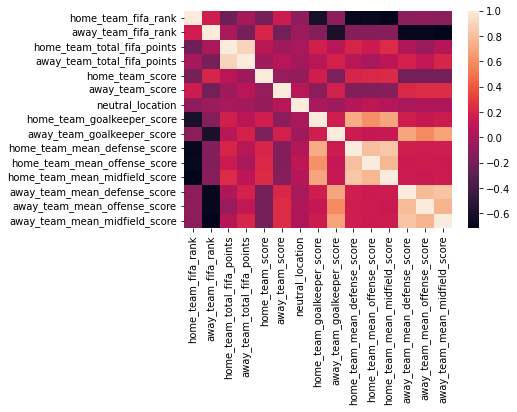

In [4]:
# compute correlations between features
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

### _Takeaways_

1. Scores of different positions within the same team and same match are highly positively correlated.
2. Team FIFA rank and positions' scores are highly negatively correlated.

### Plotting features - Histogram

To understand data further, we plot histograms of all numerical features.

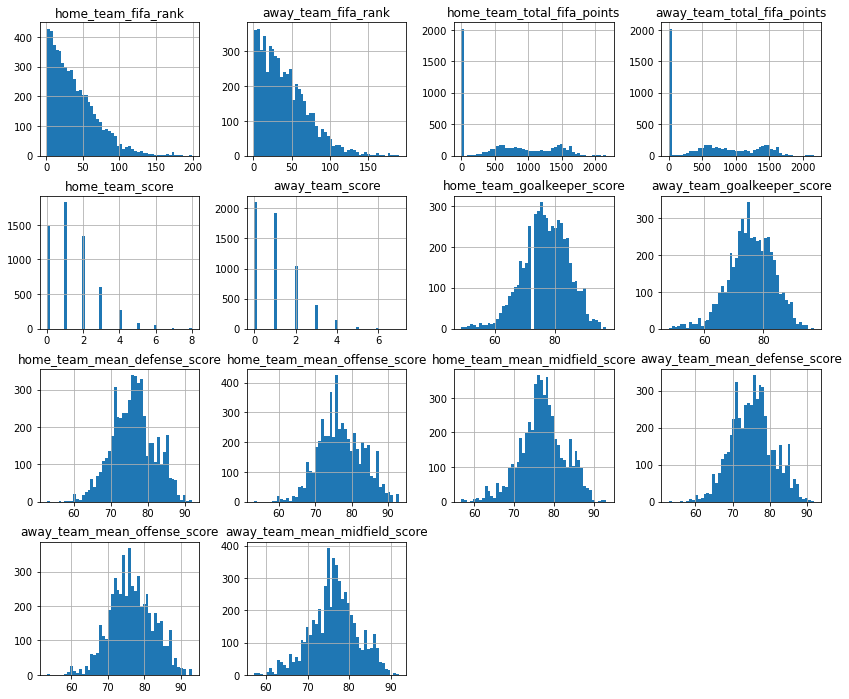

In [5]:
data.hist(bins=50, figsize=(14, 12))
plt.show()

### _Takeaways_

1. FIFA points columns (_home_team_total_fifa_points_ and _away_team_total_fifa_points_) have a large number of zeroes, which seems like a problem with the data and needs to be investigated further.
2. _home_team_goalkeeper_score_ seems to have a gap at around 72.
3. Most other data roughly follows normal distributions.

### Probing FIFA points

In order to clean the data, we first need to understand why there are large numbers of zero values in the FIFA points columns.

In [6]:
# select all rows where home team fifa points is zero
zero_points = data.query('home_team_total_fifa_points == 0')
zero_points.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.0,84.0,86.5,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,NaN,90.0,NaN,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.0,88.0,76.2,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.0,74.0,80.5,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.0,NaN,79.5,85.0,81.5,NaN,81.7,65.8


In [7]:
# printing them in descending order by date
zero_points.sort_values(by = 'date', ascending=False).head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2016,2011-08-10,Wales,Australia,Europe,Oceania,112,22,0,0,1,...,No,Lose,75.0,80.0,74.2,71.0,80.2,72.5,76.7,71.0
2001,2011-08-10,Israel,Côte d'Ivoire,Europe,Africa,32,15,0,0,3,...,No,Lose,78.0,72.0,67.0,69.0,73.8,75.8,83.3,77.2
1989,2011-08-10,Austria,Slovakia,Europe,Europe,66,29,0,0,1,...,No,Lose,75.0,72.0,74.0,74.0,74.8,74.8,77.3,74.2
1990,2011-08-10,Belarus,Bulgaria,Europe,Europe,42,48,0,0,1,...,No,Win,75.0,77.0,63.0,71.0,72.2,71.2,75.3,75.0
1991,2011-08-10,Bosnia and Herzegovina,Greece,Europe,Europe,41,13,0,0,0,...,No,Draw,76.0,74.0,72.5,78.3,77.5,75.5,76.3,75.5


Interesting... All zero values seem to be between the dates of 2004-09-03 and 2011-08-10.

We need to make sure that all values between these dates are zero.

In [8]:
# printing all values not equal to zero and lower than the upper boundary (home team)
nonzero_points = data.query('home_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


In [9]:
# printing all values not equal to zero and lower than the upper boundary (away team)
nonzero_points = data.query('away_team_total_fifa_points != 0')
nonzero_points[nonzero_points['date'] <= dt.date(2011, 8, 10)]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


We found something! It seems like the dataset is missing values for the fifa points before 2011-08-10, this will need to be cleaned up

### Data Cleansing

Now that we understand the data better, it is time to clean it up before training the model.

### Position scores

From printing the first few values of the data, we also realised there were some null (or NaN) values at in the columns displaying the scores of the different positions (home team defense, away team goalkeeper, etc).

Nonetheless, as seen in the correlations diagram, there is a strong correlation between one position's score and the score of the other positions (within the same match). Therefore, we have chosen to fill in the NaN values with the average of the other positions within the team each match.

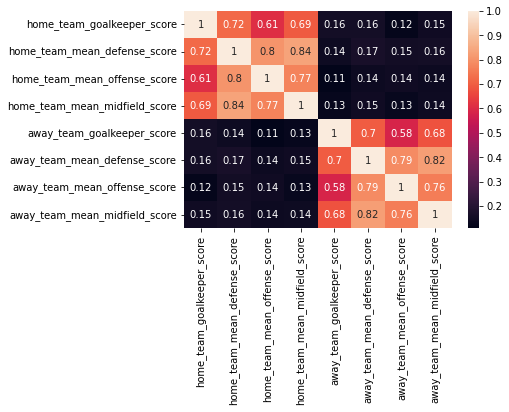

In [10]:
# compute correlations between team points
corr = data[['home_team_goalkeeper_score', \
             'home_team_mean_defense_score', \
             'home_team_mean_offense_score',\
             'home_team_mean_midfield_score', \
             'away_team_goalkeeper_score', \
             'away_team_mean_defense_score', \
             'away_team_mean_offense_score', \
             'away_team_mean_midfield_score']].corr()

heatmap(corr, annot=True)

plt.show()

In [11]:
# remember NaN values are ignored when calculating the average
home_mean = data[['home_team_goalkeeper_score', \
                  'home_team_mean_defense_score', \
                  'home_team_mean_offense_score',\
                  'home_team_mean_midfield_score']].mean(axis=1)

home_mean.head()

0    89.825
1    66.750
2    76.550
3    78.800
4    82.000
dtype: float64

In [12]:
clean_data = data
for i, col in enumerate(clean_data):
    clean_data.iloc[:, i] = data.iloc[:, i].fillna(home_mean)
    
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,0,0,1,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,0,0,2,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,0,0,2,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,0,0,3,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,0,0,1,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


In [13]:
# checking if there are any remaining NaN values
data_nan = clean_data[clean_data.isna().any(axis=1)]
data_nan.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score


Perfect! As we can see we have been able to replace all NaN values in the position scores section with the averages of the teams' scores.

### FIFA points cleanup

Given the values equal to zero in the FIFA points columns, we want to understand better how to get clean them.

In [14]:
# indentifying the data with FIFA points
mask = clean_data['date'] > dt.date(2011, 8, 10)
data_post2011 = clean_data.loc[mask]

data_post2011.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
2017,2011-08-27,Angola,Congo DR,Africa,Africa,96,127,338,221,1,...,No,Lose,70.0,67.066667,67.066667,69.7,61.5,69.2,69.7,70.0
2018,2011-09-02,Albania,France,Europe,Europe,57,15,546,918,1,...,No,Lose,70.0,86.000000,70.400000,69.7,71.5,82.5,83.0,84.5
2019,2011-09-02,Argentina,Venezuela,South America,South America,9,44,1016,615,1,...,No,Win,77.0,64.000000,80.800000,88.3,85.2,72.2,73.7,75.5
2020,2011-09-02,Belarus,Bosnia and Herzegovina,Europe,Europe,41,39,645,655,0,...,No,Lose,75.0,76.000000,63.200000,67.3,68.0,72.0,77.7,78.0
2021,2011-09-02,Bulgaria,England,Europe,Europe,51,4,585,1176,0,...,No,Lose,80.0,83.000000,70.800000,73.7,73.5,84.0,81.3,85.8


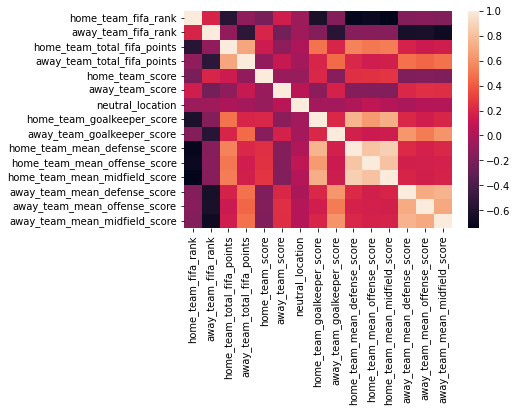

In [15]:
corr = data_post2011.corr()

heatmap(corr)

plt.show()

Interesting... it seems like there are some higher correlations between FIFA rank and FIFA points when data is nonzero.

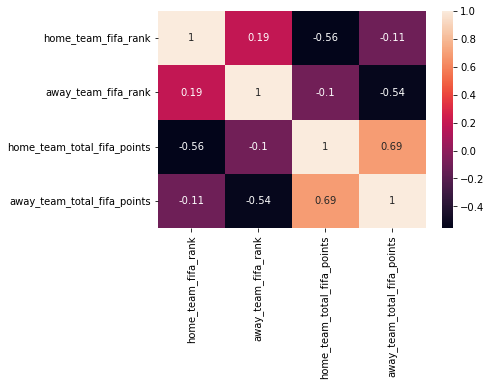

In [16]:
# compute correlations between features
corr = data_post2011[['home_team_fifa_rank', \
                      'away_team_fifa_rank', \
                      'home_team_total_fifa_points', \
                      'away_team_total_fifa_points']].corr()

heatmap(corr, annot=True)

plt.show()

Given the high correlation between FIFA rank and FIFA points, it seems like we can drop the FIFA points column with little impact on the performance of the model.

In [17]:
clean_data = clean_data.drop(columns=['home_team_total_fifa_points','away_team_total_fifa_points'])
clean_data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_score,away_team_score,tournament,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,Europe,Europe,3,67,1,1,Friendly,...,No,Draw,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,Europe,Europe,94,14,2,1,FIFA World Cup qualification,...,No,Win,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,Europe,Europe,90,7,2,2,FIFA World Cup qualification,...,No,Draw,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,Europe,Europe,25,76,3,0,FIFA World Cup qualification,...,No,Win,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,Europe,Europe,15,87,1,1,FIFA World Cup qualification,...,No,Draw,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


### Other cleanup

In order to feed the model the right data, we clean up further by dropping the date, continents, tournament, city, country and neutral location.

In [18]:
clean_data1 = clean_data

In [19]:
# Continents
clean_data1['home_team_continent'].unique()

array(['Europe', 'Africa', 'South America', 'North America', 'Oceania',
       'Asia'], dtype=object)

In [20]:
clean_data1['home_team_continent'] = clean_data1['home_team_continent'].map({'Europe':1, \
                                                                             'Africa':2, \
                                                                             'South America':3, \
                                                                             'North America':4, \
                                                                             'Oceania':5, \
                                                                             'Asia':6})
clean_data1['away_team_continent'] = clean_data1['away_team_continent'].map({'Europe':1, \
                                                                             'Africa':2, \
                                                                             'South America':3, \
                                                                             'North America':4, \
                                                                             'Oceania':5, \
                                                                             'Asia':6})

In [21]:
# Tournament
clean_data1['tournament'].unique()

array(['Friendly', 'FIFA World Cup qualification', "King's Cup",
       'CFU Caribbean Cup', 'Confederations Cup', 'Gold Cup',
       'EAFF Championship', 'African Cup of Nations',
       'Lunar New Year Cup', 'Cyprus International Tournament',
       'Kirin Cup', 'FIFA World Cup', 'UEFA Euro qualification',
       'African Cup of Nations qualification', 'Copa del Pacífico',
       'Copa América', 'AFC Asian Cup', 'UEFA Euro', 'COSAFA Cup',
       'Baltic Cup', 'UNCAF Cup', 'Nations Cup', 'Copa Confraternidad',
       'Superclásico de las Américas', 'Nehru Cup',
       'African Nations Championship', 'Kirin Challenge Cup', 'OSN Cup',
       'CFU Caribbean Cup qualification', 'Intercontinental Cup',
       'UEFA Nations League',
       'African Nations Championship qualification',
       'CONCACAF Nations League', 'Arab Cup'], dtype=object)

In [22]:
clean_data1['tournament'] = (clean_data1['tournament'] == 'Friendly').astype(int) # 1 Friendly 0 Else

In [23]:
# Drop city and country
clean_data1 = clean_data1.drop(columns=['city', 'country'])

In [24]:
# Neutral location
clean_data1['neutral_location'].unique()

array([False,  True])

In [25]:
clean_data1['neutral_location'] = clean_data1['neutral_location'].map({True:1, False:0})

In [26]:
# Shoot out
clean_data1['shoot_out'].unique()

array(['No', 'Yes'], dtype=object)

In [27]:
# if shoot out then equivalent to Draw in world cup group stage
clean_data1['home_team_result'] = np.where(clean_data1['shoot_out']=='Yes', 'Draw', clean_data1['home_team_result'])
clean_data1 = clean_data1.drop(columns=['shoot_out'])

In [28]:
# Home team result
clean_data1['home_team_result'].unique()

array(['Draw', 'Win', 'Lose'], dtype=object)

In [29]:
clean_data1['home_team_result'] = clean_data1['home_team_result'].map({'Win':1, 'Draw':0, 'Lose':-1})

In [30]:
clean_data1 = clean_data1.drop(columns=['home_team_score','away_team_score'])

In [31]:
clean_data1.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,tournament,neutral_location,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2004-09-03,Spain,Scotland,1,1,3,67,1,0,0,94.00,84.0,86.50,89.3,89.5,80.2,79.7,81.8
1,2004-09-04,Albania,Greece,1,1,94,14,0,0,1,66.75,90.0,66.75,59.0,74.5,82.8,83.7,85.2
2,2004-09-04,Austria,England,1,1,90,7,0,0,0,83.00,88.0,76.20,73.0,74.0,90.5,88.7,91.2
3,2004-09-04,Croatia,Hungary,1,1,25,76,0,0,1,77.00,74.0,80.50,78.7,79.0,71.8,75.7,70.2
4,2004-09-04,Denmark,Ukraine,1,1,15,87,0,0,0,82.00,82.0,79.50,85.0,81.5,82.0,81.7,65.8


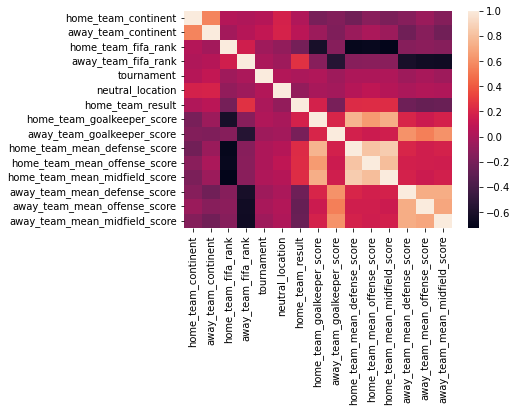

In [32]:
corr = clean_data1.corr()

heatmap(corr)

plt.show()

In [33]:
clean_data1 = clean_data1.drop(columns=['home_team_continent','away_team_continent'])

In [34]:
# copy final clean data with date for later use, remove for algorithms
date_data = clean_data1
clean_data1 = clean_data1.drop(columns=['date'])

In [35]:
clean_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5641 entries, 0 to 5640
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team                      5641 non-null   object 
 1   away_team                      5641 non-null   object 
 2   home_team_fifa_rank            5641 non-null   int64  
 3   away_team_fifa_rank            5641 non-null   int64  
 4   tournament                     5641 non-null   int64  
 5   neutral_location               5641 non-null   int64  
 6   home_team_result               5641 non-null   int64  
 7   home_team_goalkeeper_score     5641 non-null   float64
 8   away_team_goalkeeper_score     5641 non-null   float64
 9   home_team_mean_defense_score   5641 non-null   float64
 10  home_team_mean_offense_score   5641 non-null   float64
 11  home_team_mean_midfield_score  5641 non-null   float64
 12  away_team_mean_defense_score   5641 non-null   f

## Training and validation

[CHANGE]

### Split the Data Set

Before we start, we need to split the data set into a training set and a validation set, as well as selecting the relevant columns.

In [36]:
# convert team names into dummy/indicator variables
clean_data1 = pd.get_dummies(clean_data1)

# extract match result from dataset
X = clean_data1.drop('home_team_result', axis=1)
y = clean_data1['home_team_result']

# split the dataset into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=33)
#X_hold_test, X_test, y_hold_test, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=33)

### Scale the Data Set:
Next we standardise the data set since the features are reported on different scales. 

Common scaling techniques include normalisation and binarisation. 

`sklearn.preprocessing` provides various feature scaling modules (use `help(preprocessing)` to check the documentation of these modules). 

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
#X_hold_test = scaler.transform(X_hold_test)

In [38]:
random_state = np.random.RandomState(33)

We will now apply 9 algorithms to obtain results:
1. 

### _Logistic Regression_

              precision    recall  f1-score   support

          -1       0.47      0.50      0.49       321
           0       0.31      0.11      0.16       321
           1       0.55      0.75      0.64       487

    accuracy                           0.50      1129
   macro avg       0.44      0.46      0.43      1129
weighted avg       0.46      0.50      0.46      1129



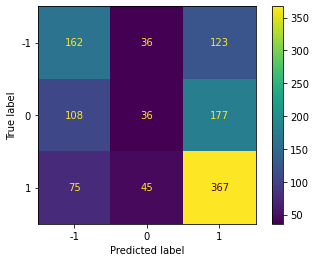

In [39]:
lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train, y_train)
y_lr = lr.predict(X_val)

y_lr_prob = lr.predict_proba(X_val)[:, -1]  # probability estimates of the positive class
y_lr_score = lr.decision_function(X_val)    # confidence scores

print(classification_report(y_val,y_lr))
ConfusionMatrixDisplay.from_predictions(y_val,y_lr);

### _Naive Bayes_

              precision    recall  f1-score   support

          -1       0.47      0.13      0.21       321
           0       0.28      0.88      0.43       321
           1       0.69      0.07      0.12       487

    accuracy                           0.32      1129
   macro avg       0.48      0.36      0.25      1129
weighted avg       0.51      0.32      0.23      1129



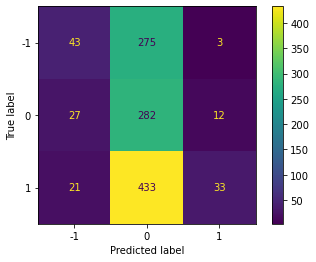

In [40]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_nb = nb.predict(X_val)

print(classification_report(y_val,y_nb))
ConfusionMatrixDisplay.from_predictions(y_val,y_nb);

### _Linear Discriminant Analysis (LDA)_

              precision    recall  f1-score   support

          -1       0.48      0.50      0.49       321
           0       0.34      0.14      0.19       321
           1       0.55      0.75      0.63       487

    accuracy                           0.50      1129
   macro avg       0.45      0.46      0.44      1129
weighted avg       0.47      0.50      0.47      1129



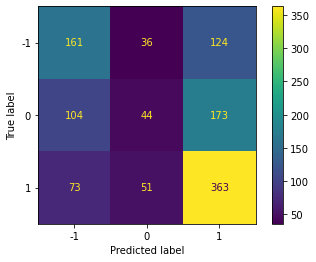

In [41]:
lda = LDA()
lda.fit(X_train, y_train)
y_lda = lda.predict(X_val)

print(classification_report(y_val,y_lda))
ConfusionMatrixDisplay.from_predictions(y_val,y_lda);

### _Quadratic Discriminant Analysis (QDA)_

              precision    recall  f1-score   support

          -1       0.34      0.50      0.41       321
           0       0.29      0.48      0.36       321
           1       0.50      0.12      0.20       487

    accuracy                           0.33      1129
   macro avg       0.38      0.37      0.32      1129
weighted avg       0.39      0.33      0.30      1129



/Users/rafa/opt/anaconda3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


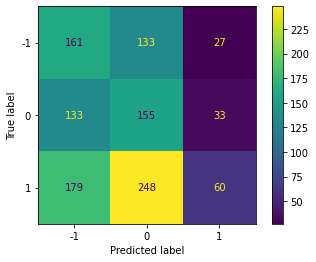

In [42]:
qda = QDA()
qda.fit(X_train, y_train)
y_qda = qda.predict(X_val)

print(classification_report(y_val,y_qda))
ConfusionMatrixDisplay.from_predictions(y_val,y_qda);

### _Random Forest Classifier (RFC)_

              precision    recall  f1-score   support

          -1       0.46      0.49      0.47       321
           0       0.29      0.09      0.13       321
           1       0.54      0.76      0.63       487

    accuracy                           0.49      1129
   macro avg       0.43      0.45      0.41      1129
weighted avg       0.44      0.49      0.44      1129



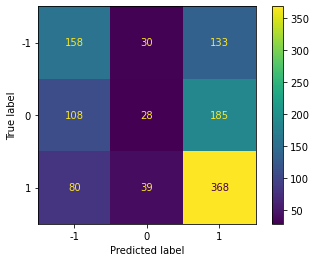

In [43]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_rfc = rfc.predict(X_val)

print(classification_report(y_val,y_rfc))
ConfusionMatrixDisplay.from_predictions(y_val,y_rfc);

### _Support Vector Classifier (SVC)_

              precision    recall  f1-score   support

          -1       0.48      0.47      0.47       321
           0       0.30      0.07      0.11       321
           1       0.52      0.79      0.63       487

    accuracy                           0.49      1129
   macro avg       0.43      0.44      0.40      1129
weighted avg       0.44      0.49      0.44      1129



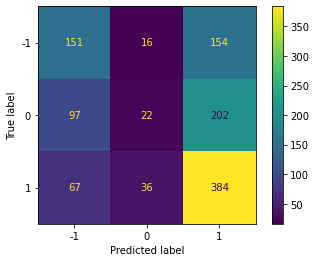

In [44]:
from sklearn.svm import SVC

svc = SVC(kernel='rbf', random_state=random_state)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_val)

print(classification_report(y_val,y_svc))
ConfusionMatrixDisplay.from_predictions(y_val,y_svc);

### _Decision Tree Classifier_

              precision    recall  f1-score   support

          -1       0.37      0.41      0.39       321
           0       0.29      0.26      0.27       321
           1       0.50      0.51      0.50       487

    accuracy                           0.41      1129
   macro avg       0.39      0.39      0.39      1129
weighted avg       0.40      0.41      0.41      1129



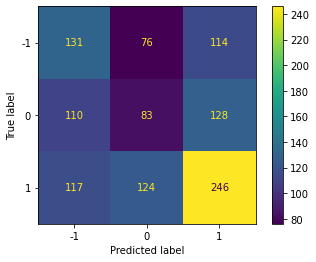

In [45]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', random_state=random_state)
dtc.fit(X_train, y_train)
y_dtc = dtc.predict(X_val)

print(classification_report(y_val,y_dtc))
ConfusionMatrixDisplay.from_predictions(y_val,y_dtc);

### _Adaptive Boosting Classifier_

              precision    recall  f1-score   support

          -1       0.44      0.54      0.49       321
           0       0.25      0.04      0.07       321
           1       0.53      0.75      0.62       487

    accuracy                           0.49      1129
   macro avg       0.41      0.44      0.39      1129
weighted avg       0.43      0.49      0.43      1129



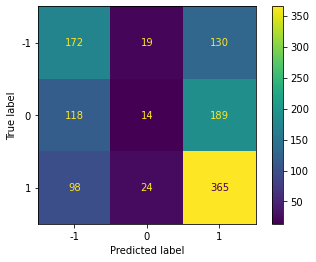

In [46]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
y_abc = abc.predict(X_val)

print(classification_report(y_val,y_abc))
ConfusionMatrixDisplay.from_predictions(y_val,y_abc);

### _Multi-Layer Perceptron (MLP)_

              precision    recall  f1-score   support

          -1       0.48      0.52      0.50       321
           0       0.10      0.00      0.01       321
           1       0.53      0.84      0.65       487

    accuracy                           0.51      1129
   macro avg       0.37      0.45      0.39      1129
weighted avg       0.39      0.51      0.42      1129



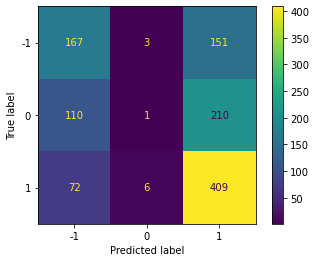

In [47]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=15, max_iter=1000000)
mlp.fit(X_train, y_train)
y_mlp = mlp.predict(X_val)

print(classification_report(y_val,y_mlp))
ConfusionMatrixDisplay.from_predictions(y_val,y_mlp);

,LR,NB,LDA,QDA,RFC,SVC,DTC,ABC,MLP
0,0.500443,0.317095,0.5031,0.333038,0.4907,0.493357,0.40744,0.488043,0.511072


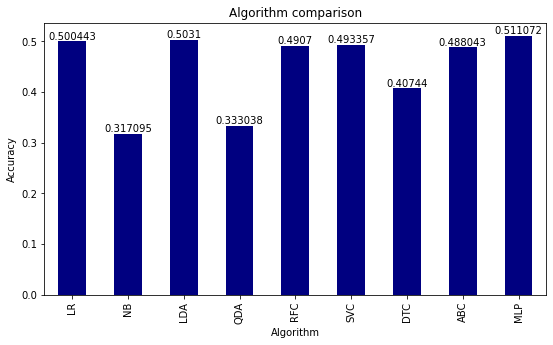

In [48]:
# create a dictionary variable with keys being algorithms names and values being classification predictions
results = dict(zip(['LR', 'NB', 'LDA', 'QDA', 'RFC', 'SVC', 'DTC', 'ABC', 'MLP'], \
                   [y_lr, y_nb, y_lda, y_qda, y_rfc, y_svc, y_dtc, y_abc, y_mlp]))

# create a dictionary variable with keys being algorithm names and values being classification accuracy
accuracy = {}
for algorithm, prediction in results.items():
    accuracy[algorithm] = accuracy_score(y_val, prediction)
    
accuracy = pd.DataFrame(data=accuracy, index=[0])
ax = accuracy.T.plot.bar(
    title='Algorithm comparison',
    xlabel='Algorithm',
    ylabel='Accuracy',
    color='navy',
    figsize=(9, 5),
    legend=False,
)
ax.bar_label(ax.containers[0])

accuracy

### ROC Curve
A Receiver Operating Characteristic curve (ROC curve) is a graphical plot of the true positive rate (TPR) against the false positive rate (FPR), using different threshold settings:

In [49]:
# binarise output
y_train_bin = label_binarize(y_train, classes=[-1, 0, 1])
y_val_bin = label_binarize(y_val, classes=[-1, 0, 1])

# learn to predict each class against the other, using MLP which was the most accurate model
classifier = OneVsRestClassifier(MLPClassifier(alpha=15, max_iter=1000000))
y_score = classifier.fit(X_train, y_train_bin).predict_proba(X_val)

# compute ROC curve and area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in [-1, 0, 1]:
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

We now proceed to compute and plot the micro and macro averages.

In [50]:
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in [-1, 0, 1]]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in [-1, 0, 1]:
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

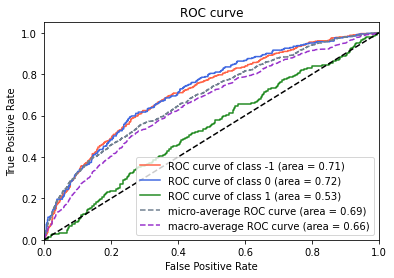

In [51]:
# plotting results   
plt.figure()

# curves for each class
plt.plot(
    fpr[-1],
    tpr[-1],
    color='tomato',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(-1, roc_auc[-1]),
)
plt.plot(
    fpr[0],
    tpr[0],
    color='royalblue',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(0, roc_auc[0]),
)
plt.plot(
    fpr[1],
    tpr[1],
    color='forestgreen',
    label='ROC curve of class {0} (area = {1:0.2f})'.format(1, roc_auc[1]),
)

# curves for micro and macro averages
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="slategrey",
    linestyle="--",
)
plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="darkorchid",
    linestyle="--",
)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

## Prediction

[CHANGE]

### Building missing features
First we need to build the missing features into the prediction dataset in order to feed the model the correct inputs.

In [83]:
# reading raw .csv file
pred_data = pd.read_csv('dataset/worldcup_2022.csv')

# date is imported as string, we change to datetime for easier cleaning
pred_data['date'] = pd.to_datetime(pred_data['date']).dt.date

pred_data.tail()

,date,home_team,away_team
43,2022-12-01,Costa Rica,Germany
44,2022-12-02,Ghana,Uruguay
45,2022-12-02,Korea Republic,Portugal
46,2022-12-02,Serbia,Switzerland
47,2022-12-02,Cameroon,Brazil


In [84]:
# filling in tournament and neutral location features
pred_data = pred_data.assign(tournament=np.zeros(48, dtype=int))

# Qatar plays in indices 0 and 35
nloc = np.full(48, 1)
nloc[0], nloc[35] = 0, 0
pred_data = pred_data.assign(neutral_location=nloc)

pred_data.head()

,date,home_team,away_team,tournament,neutral_location
0,2022-11-20,Qatar,Ecuador,0,0
1,2022-11-21,Senegal,Netherlands,0,1
2,2022-11-21,England,IR Iran,0,1
3,2022-11-21,USA,Wales,0,1
4,2022-11-22,France,Australia,0,1


Since the tournament is not friendly, we assign 0 to all values in the feature (as with `clean_data1`).

Similarly, neutral location is only False (0) for Qatar.

In [85]:
# filling in tournament and neutral location features
pred_data = pred_data.assign(tournament=np.zeros(48, dtype=int))

# Qatar plays in indices 0 and 35
nloc = np.full(48, 1)
nloc[0], nloc[35] = 0, 0
pred_data = pred_data.assign(neutral_location=nloc)

pred_data.head()

,date,home_team,away_team,tournament,neutral_location
0,2022-11-20,Qatar,Ecuador,0,0
1,2022-11-21,Senegal,Netherlands,0,1
2,2022-11-21,England,IR Iran,0,1
3,2022-11-21,USA,Wales,0,1
4,2022-11-22,France,Australia,0,1


In [86]:
# initialise remaining features
pred_data = pred_data.assign(home_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(away_team_fifa_rank=np.zeros(48, dtype=int))
pred_data = pred_data.assign(home_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_goalkeeper_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(home_team_mean_midfield_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_defense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_offense_score=np.zeros(48, dtype=float))
pred_data = pred_data.assign(away_team_mean_midfield_score=np.zeros(48, dtype=float))

pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-11-21,Senegal,Netherlands,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-11-21,England,IR Iran,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-11-21,USA,Wales,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-11-22,France,Australia,0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now have all the features we need initialised, but still need to fill in the relevant values for team ranks and positions' scores.

We do this by finding the scores of the last match each country played.

In [87]:
# finding all countries that play in the world cup
countries_22 = np.unique(pred_data[['home_team', 'away_team']].values)
countries_22

array(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Cameroon',
       'Canada', 'Costa Rica', 'Croatia', 'Denmark', 'Ecuador', 'England',
       'France', 'Germany', 'Ghana', 'IR Iran', 'Japan', 'Korea Republic',
       'Mexico', 'Morocco', 'Netherlands', 'Poland', 'Portugal', 'Qatar',
       'Saudi Arabia', 'Senegal', 'Serbia', 'Spain', 'Switzerland',
       'Tunisia', 'USA', 'Uruguay', 'Wales'], dtype=object)

In [94]:
# function to update missing prediction data with last match outcomes
def update_pred_data(country):
    last_home = date_data.query("home_team == @country").tail(1)
    last_away = date_data.query("away_team == @country").tail(1)
    
    
    pred_data['home_team_fifa_rank'] = np.where(pred_data['home_team'] == country, \
                                                last_home['home_team_fifa_rank'].item(), \
                                                pred_data['home_team_fifa_rank'])
    pred_data['home_team_goalkeeper_score'] = np.where(pred_data['home_team'] == country, \
                                                       last_home['home_team_goalkeeper_score'].item(), \
                                                       pred_data['home_team_goalkeeper_score'])
    pred_data['home_team_mean_defense_score'] = np.where(pred_data['home_team'] == country, \
                                                         last_home['home_team_mean_defense_score'].item(), \
                                                         pred_data['home_team_mean_defense_score'])
    pred_data['home_team_mean_offense_score'] = np.where(pred_data['home_team'] == country, \
                                                         last_home['home_team_mean_offense_score'].item(), \
                                                         pred_data['home_team_mean_offense_score'])
    pred_data['home_team_mean_midfield_score'] = np.where(pred_data['home_team'] == country, \
                                                          last_home['home_team_mean_midfield_score'].item(), \
                                                          pred_data['home_team_mean_midfield_score'])

    pred_data['away_team_fifa_rank'] = np.where(pred_data['away_team'] == country, \
                                                last_home['away_team_fifa_rank'].item(), \
                                                pred_data['away_team_fifa_rank'])
    pred_data['away_team_goalkeeper_score'] = np.where(pred_data['away_team'] == country, \
                                                       last_home['away_team_goalkeeper_score'].item(), \
                                                       pred_data['away_team_goalkeeper_score'])
    pred_data['away_team_mean_defense_score'] = np.where(pred_data['away_team'] == country, \
                                                         last_home['away_team_mean_defense_score'].item(), \
                                                         pred_data['away_team_mean_defense_score'])
    pred_data['away_team_mean_offense_score'] = np.where(pred_data['away_team'] == country, \
                                                         last_home['away_team_mean_offense_score'].item(), \
                                                         pred_data['away_team_mean_offense_score'])
    pred_data['away_team_mean_midfield_score'] = np.where(pred_data['away_team'] == country, \
                                                          last_home['away_team_mean_midfield_score'].item(), \
                                                          pred_data['away_team_mean_midfield_score'])

In [95]:
# loop through all countries to update prediction data
for i in countries_22:
    if i != 'Qatar':
        update_pred_data(i)

In [98]:
pred_data.head()

,date,home_team,away_team,tournament,neutral_location,home_team_fifa_rank,away_team_fifa_rank,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,2022-11-20,Qatar,Ecuador,0,0,0,50,0.0,73.0,0.0,0.0,0.0,72.8,76.3,77.8
1,2022-11-21,Senegal,Netherlands,0,1,20,37,83.0,76.0,79.0,80.7,79.0,75.0,79.7,78.0
2,2022-11-21,England,IR Iran,0,1,5,36,83.0,75.0,85.0,88.0,84.0,73.0,80.0,73.8
3,2022-11-21,USA,Wales,0,1,12,1,77.0,89.0,75.8,77.7,75.8,80.8,85.7,85.5
4,2022-11-22,France,Australia,0,1,3,49,87.0,70.0,84.2,88.3,86.8,72.8,67.7,72.8


# [END PROJECT]